# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.


Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [67]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [68]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [69]:
df = pd.read_csv('YearPredictionMSD.txt', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [113]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [72]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [73]:
set_random_seed(42)

Отмасштабируем данные с помощью нашего скалера

In [74]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

Обучим Ridge

In [76]:
model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

Посмотрим RMSE для полученной модели

In [77]:
rmse_for_model = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [214]:
const_pred = np.full_like(y_test, fill_value=y_train.mean()) #заполняем предикт константой по среднему числу
best_rmse_metric = np.sqrt(mean_squared_error(y_test, const_pred))
best_rmse_metric

10.863228020678134

Лучшее RMSE - 10.86

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [216]:
train_size = 10000  # Размер среза для тренировочной выборки
test_size = 2000    # Размер среза для тестовой выборки

X_train_slice = X_train[:train_size, :]  
y_train_slice = y_train[:train_size]     
X_test_slice = X_test[:test_size, :]    
y_test_slice = y_test[:test_size]  

In [217]:
# Поскольку разброс данных большой, отмасштабируем их
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_slice)
X_test_scaled = scaler.transform(X_test_slice)

In [218]:
# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_slice, dtype=torch.float32).view(-1, 1) # работает как numpy.reshape() для PyTorch
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_slice, dtype=torch.float32).view(-1, 1)

Модель линейной регрессии, которая состоит только из одного Linear слоя
Пример медели взят отсюда: https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu

In [220]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # 1 слой

    def forward(self, x):
        return self.linear(x)

In [221]:
input_dim = X_train_tensor.shape[1]  # Количество признаков
model = LinearRegressionModel(input_dim)

In [222]:
train_losses = []
test_losses = []
train_rmse = []
test_rmse = []
num_epochs = 10
learning_rate = 0.01

In [223]:
for epoch in range(num_epochs):
    model.train()
    y_pred_train = model(X_train_tensor)
    loss_train = ((y_pred_train - y_train_tensor) ** 2).mean()
    loss_train.backward()

    # Обновление весов вручную
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    model.zero_grad() # Обнуление градиентов после каждого шага
    rmse_train = torch.sqrt(loss_train).item()

    # Оценка на тестовой выборке
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        loss_test = ((y_pred_test - y_test_tensor) ** 2).mean()
        rmse_test = torch.sqrt(loss_test).item()
    
    # Сохранение значений потерь и RMSE
    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())
    train_rmse.append(rmse_train)
    test_rmse.append(rmse_test)

    print(f"Эпоха {epoch+1}/{num_epochs}, Loss (Train): {loss_train.item():.4f}, Loss (Test): {loss_test.item():.4f}, RMSE (Train): {rmse_train:.4f}, RMSE (Test): {rmse_test:.4f}")

Эпоха 1/25, Loss (Train): 3996146.0000, Loss (Test): 3828800.5000, RMSE (Train): 1999.0363, RMSE (Test): 1956.7321
Эпоха 2/25, Loss (Train): 3837901.2500, Loss (Test): 3676924.0000, RMSE (Train): 1959.0563, RMSE (Test): 1917.5308
Эпоха 3/25, Loss (Train): 3685923.2500, Loss (Test): 3531078.0000, RMSE (Train): 1919.8759, RMSE (Test): 1879.1163
Эпоха 4/25, Loss (Train): 3539964.0000, Loss (Test): 3391021.2500, RMSE (Train): 1881.4792, RMSE (Test): 1841.4725
Эпоха 5/25, Loss (Train): 3399784.0000, Loss (Test): 3256523.0000, RMSE (Train): 1843.8503, RMSE (Test): 1804.5839
Эпоха 6/25, Loss (Train): 3265155.5000, Loss (Test): 3127362.0000, RMSE (Train): 1806.9741, RMSE (Test): 1768.4349
Эпоха 7/25, Loss (Train): 3135858.5000, Loss (Test): 3003325.0000, RMSE (Train): 1770.8356, RMSE (Test): 1733.0104
Эпоха 8/25, Loss (Train): 3011681.7500, Loss (Test): 2884208.2500, RMSE (Train): 1735.4198, RMSE (Test): 1698.2957
Эпоха 9/25, Loss (Train): 2892422.2500, Loss (Test): 2769815.5000, RMSE (Train):

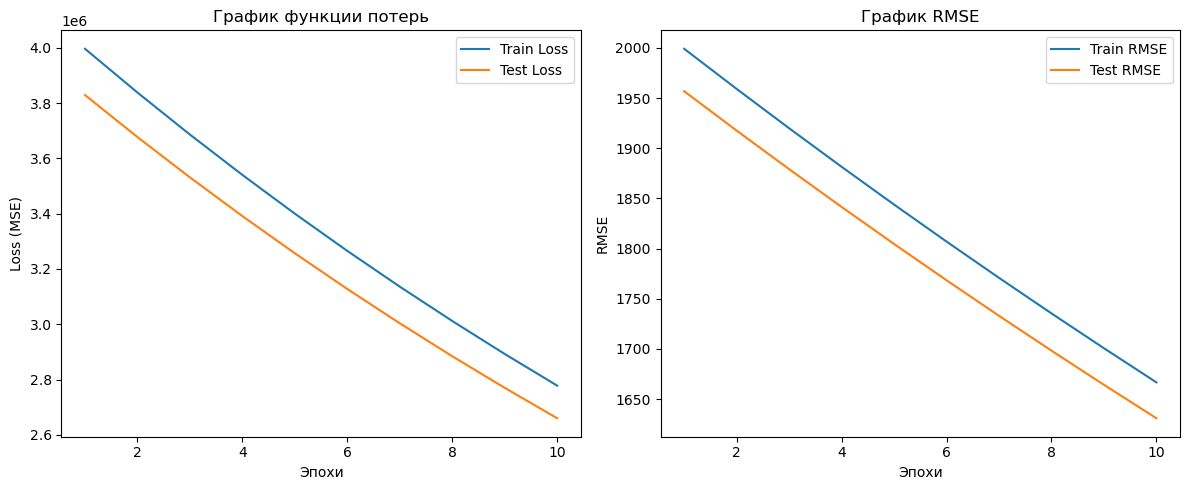

In [225]:
# График потерь (Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1,  11), train_losses, label='Train Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.xlabel('Эпохи')
plt.ylabel('Loss (MSE)')
plt.title('График функции потерь')
plt.legend()

# График RMSE
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_rmse, label='Train RMSE')
plt.plot(range(1, 11), test_rmse, label='Test RMSE')
plt.xlabel('Эпохи')
plt.ylabel('RMSE')
plt.title('График RMSE')
plt.legend()

plt.tight_layout()
plt.show()

Рукописная функция работает на представленном срезе данных. Показатели метрик улучшаются с количеством эпох

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

Тут очень долго делать ссылки для каждой ячейки в отдельности, поэтому тут все материалы, которые были использованы для данной задачи (это было долго :) ):
1) Много хорошего про настройку параметров - https://www.kdnuggets.com/2022/12/tuning-adam-optimizer-parameters-pytorch.html#:~:text=Learning%20Rate%20(alpha%20or%20Lr)&text=An%20optimal%20learning%20rate%20value,in%20most%20of%20the%20cases.
2) Тоже про подбор параметров - https://habr.com/ru/articles/724418/
3) Про RMSE - https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii
4) Про Adam - https://ru.eitca.org/artificial-intelligence/eitc-ai-dltf-deep-learning-with-tensorflow/tensorflow/neural-network-model/examination-review-neural-network-model/how-does-the-adam-optimizer-optimize-the-neural-network-model/
5) Про dropout - https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/
6) Про weight decay для Adam - https://stackoverflow.com/questions/44452571/what-is-the-proper-way-to-weight-decay-for-adam-optimizer

In [64]:
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset

In [160]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

In [161]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

Взяла довольно большие батчи по 512, более подробно напишу про это в 3 задаче. Если коротко, то так функция получалась более гладкой

In [207]:
train_set = TensorDataset(X_train_tensor, y_train_tensor)
test_set = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

Далее брала пример модели из интернета + дорабатывала: https://medium.com/@bao.character/how-to-use-pytorchs-nn-embedding-a-comprehensive-guide-with-examples-da00ea42e952

In [226]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) # полносвязный слой
        self.relu = nn.ReLU() #релу
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) # полносвязный слой
        self.fc3 = nn.Linear(hidden_dim, output_dim) # выход
        self.dropout = nn.Dropout(0.25)  # для регуляризации - 0.25 не очень много, но у нейронки будет всего 64 нейрона (более подробно в 3 задаче)

    def forward(self, x):
        x = self.fc1(x) #прямой проход
        x = self.relu(x) # relu
        x = self.dropout(x) #регуляризация (взяла большие батчи, поэтому помогло от переобучения)
        x = self.fc2(x) #прямой проход
        x = self.relu(x) # relu
        x = self.fc3(x) #прямой проход
        return x

In [208]:
input_dim = X_train.shape[1]
hidden_dim = 64
model = SimpleNN(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()  # MSE для регрессии
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Адам-оптимизатор с weight_decay для регуляризации

In [227]:
#много буду применять поэтому в отдельной функции
def rmse_loss(pred, target):
    return torch.sqrt(criterion(pred, target))

In [194]:
def train(model, optimizer, criterion, train_loader, test_loader, num_epochs=20):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for X_batch, y_batch in tqdm(train_loader):
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        test_loss = test(model, criterion, test_loader)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    return train_losses, test_losses

In [229]:
def test(model, criterion, test_loader):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item()
    
    test_loss = running_loss / len(test_loader)
    return test_loss

In [230]:
def inverse_transform(preds):
    # Обратное преобразование предсказаний в исходную шкалу, нужно, чтобы оценить RMSE
    return scaler.inverse_transform(preds)

def calculate_rmse(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            all_preds.append(y_pred)
            all_targets.append(y_batch)
    
    # Объединяем все батчи
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()
    
    # Обратная нормализация предсказаний и целевых значений
    all_preds_denorm = inverse_transform(all_preds)
    all_targets_denorm = inverse_transform(all_targets)

    # Рассчитываем RMSE для денормализованных данных
    rmse = np.sqrt(np.mean((all_preds_denorm - all_targets_denorm) ** 2))
    return rmse

In [209]:
num_epochs = 15
train_losses, test_losses = train(model, optimizer, criterion, train_loader, test_loader, num_epochs=num_epochs)

  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [1/15], Train Loss: 0.7088, Test Loss: 0.6678


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [2/15], Train Loss: 0.6573, Test Loss: 0.6607


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [3/15], Train Loss: 0.6475, Test Loss: 0.6527


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [4/15], Train Loss: 0.6418, Test Loss: 0.6522


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [5/15], Train Loss: 0.6380, Test Loss: 0.6519


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [6/15], Train Loss: 0.6352, Test Loss: 0.6487


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [7/15], Train Loss: 0.6328, Test Loss: 0.6463


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [8/15], Train Loss: 0.6307, Test Loss: 0.6466


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [9/15], Train Loss: 0.6291, Test Loss: 0.6468


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [10/15], Train Loss: 0.6269, Test Loss: 0.6462


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [11/15], Train Loss: 0.6260, Test Loss: 0.6460


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [12/15], Train Loss: 0.6248, Test Loss: 0.6434


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [13/15], Train Loss: 0.6231, Test Loss: 0.6464


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [14/15], Train Loss: 0.6218, Test Loss: 0.6439


  0%|          | 0/906 [00:00<?, ?it/s]

Epoch [15/15], Train Loss: 0.6214, Test Loss: 0.6430


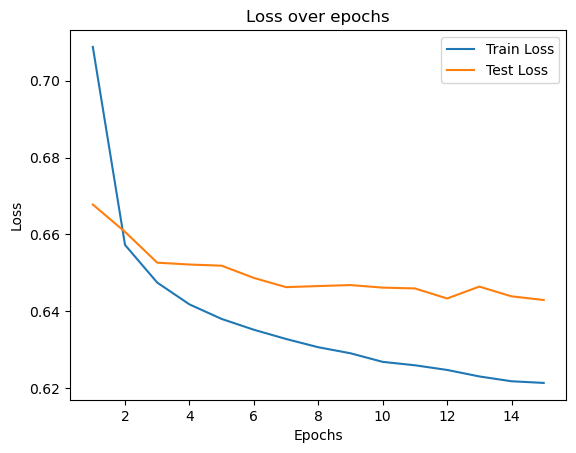

In [211]:
epochs = range(1, 15 + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [212]:
rmse_value = calculate_rmse(model, test_loader)
print(f'RMSE on test data: {rmse_value:.4f}')

RMSE on test data: 8.7523


## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

1) Все началось с полносвязной нейронки на 128 нейронов, без регуляризаторов и стандартными параметрами. Батчи взяла по 32, решила прогнать на 15 эпох. Лосс был огромный, работало чуть ли не хуже чем константная модель
2) Попробовала добавить дроп аут на 0.3, увеличить батчи до 64 и тоже прогнать на 15 эпохах. Трейн обучался хорошо, шел по диагонали, а вот трейн жутко скакал с одного значения на другое.
3) Стало понятно, что чтобы снизить шум нужно брать батчи побольше. Брала при тех же гиперпараметрах их другого пункта батчи по 128, 254, 512. Функция стала гладкой, но дико переобучалась, сначала шла вниз, потом начинала расти или вообще не менялась, при том что трейн был идеальный
4) Решила оставить батч на 512 но делать большой drop_out (0.5) и добавить weight_decay в оптимизатор. Стало лучше, скачки прекратились, но на тестовых данных обучение просто не двигалось, снова синдром переобучения
5) Решила подрезать нейроны до 64, но уменьшить drop_out до 0.25. Сработало

Итоговые параметры вышли такие:
1) Архитектура нейронки включает в себя регуляризацию через drop_out и 64 нейрона для избежания переобучения
2) Батчи взяты большие - 512, чтобы снизить шум в градиентах
3) Чтобы решить проблему с переобучением на больших батчах, также помогает дроп аут и weight_decay в оптимизаторе

Еще на начальных этапах было несколько тестов на изменение learning_rate. На функцию трейна это действительно влияло, при повышении lr, функция из диагональной ближе прижалась к оси X и стала плавнее. Однако на тест это особо не повлияло, он все равно был очень-очень шумным. Подобранный lr на трейне так и остался повыше для батчей побольше, там особых изменений не было.


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

Архитектура и многая информация взята отсюда: https://www.kaggle.com/code/ispritchin/part-iv-classification-using-pytorch-rus#%D0%90%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D0%B0-%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9-%D1%81%D0%B5%D1%82%D0%B8-%D0%B4%D0%BB%D1%8F-%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F-%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8-%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8

In [284]:
class ClassificationNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [285]:
# Для классификации по годам
output_dim_class = len(np.unique(y_train_class))  # количество уникальных годов
model_class = ClassificationNN(input_dim, hidden_dim, output_dim_class)
optimizer_class = optim.Adam(model_class.parameters(), lr=0.001)
criterion_class = nn.CrossEntropyLoss()

# Для классификации по бинам
output_dim_binned = n_bins
model_binned = ClassificationNN(input_dim, hidden_dim, output_dim_binned)
optimizer_binned = optim.Adam(model_binned.parameters(), lr=0.001)
criterion_binned = nn.CrossEntropyLoss()

Определимся с micro или macro усреднением

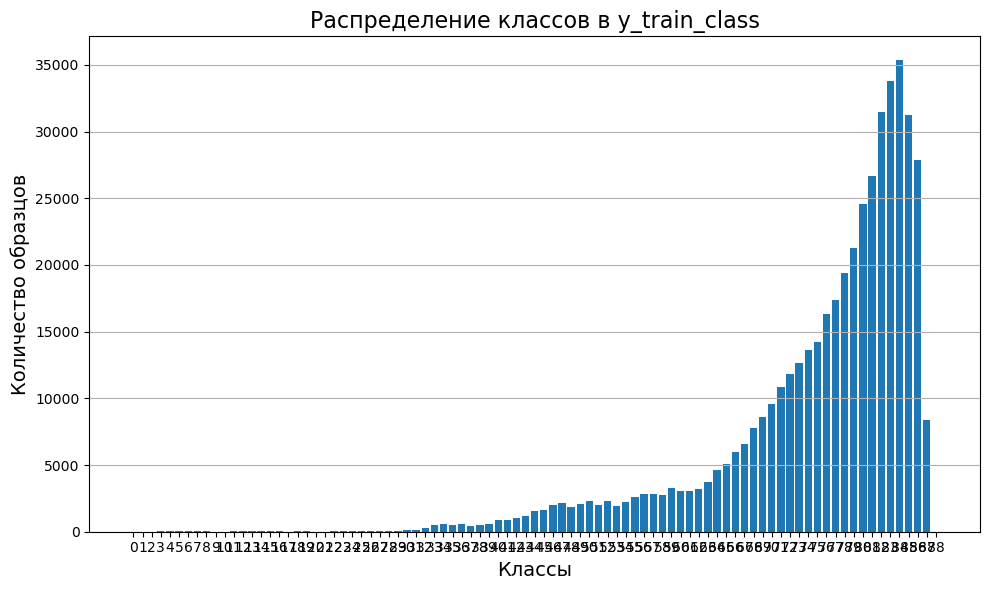

In [271]:
unique_classes, class_counts = np.unique(y_train_class, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(unique_classes.astype(str), class_counts)
plt.title('Распределение классов в y_train_class', fontsize=16)
plt.xlabel('Классы', fontsize=14)
plt.ylabel('Количество образцов', fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Выбираем macro, т.к. сильный дисбаланс классов

Тестирование - https://gist.github.com/MLWhiz/2cd4712647f72d4078caf4d76b650717

In [286]:
def test_classification(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module для классификации
        criterion - функция потерь, CrossEntropyLoss для классификации
        test_loader - DataLoader с тестовым набором данных
    ----------
    returns:
        predicts - torch.tensor с предсказаниями для тестовых объектов
    """
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            _, predicted_labels = torch.max(y_pred, 1)  # Получаем предсказанные классы
            all_preds.append(predicted_labels.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Метрики
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro')  # выбираем macro
    recall = recall_score(all_targets, all_preds, average='macro')

    print(f'Test Loss: {total_loss / len(test_loader):.4f}')
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    
    return all_preds

https://habr.com/ru/articles/456294/
https://stackoverflow.com/questions/53963183/how-to-use-kbinsdiscretizer-to-make-continuous-data-into-bins-in-sklearn

In [277]:
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [287]:
# классификация по годам
label_encoder = LabelEncoder()
y_train_class = label_encoder.fit_transform(y_train)
y_test_class = label_encoder.transform(y_test)

# классификация по бинам https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html
n_bins = 10
binning = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_train_binned = binning.fit_transform(y_train.reshape(-1, 1)).astype(int).flatten()
y_test_binned = binning.transform(y_test.reshape(-1, 1)).astype(int).flatten()

D:\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [288]:
# тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor_class = torch.tensor(y_train_class, dtype=torch.long)
y_train_tensor_binned = torch.tensor(y_train_binned, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor_class = torch.tensor(y_test_class, dtype=torch.long)
y_test_tensor_binned = torch.tensor(y_test_binned, dtype=torch.long)

In [289]:
train_dataset_class = TensorDataset(X_train_tensor, y_train_tensor_class)
test_dataset_class = TensorDataset(X_test_tensor, y_test_tensor_class)
train_loader_class = DataLoader(train_dataset_class, batch_size=64, shuffle=True)
test_loader_class = DataLoader(test_dataset_class, batch_size=64, shuffle=False)
train_dataset_binned = TensorDataset(X_train_tensor, y_train_tensor_binned)
test_dataset_binned = TensorDataset(X_test_tensor, y_test_tensor_binned)
train_loader_binned = DataLoader(train_dataset_binned, batch_size=64, shuffle=True)
test_loader_binned = DataLoader(test_dataset_binned, batch_size=64, shuffle=False)

In [290]:
input_dim = X_train.shape[1]
hidden_dim = 128

test_classification(model_class, criterion_class, test_loader_class)
test_classification(model_binned, criterion_binned, test_loader_binned)

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 108.1181
Accuracy: 0.0017, Precision: 0.0053, Recall: 0.0222
Test Loss: 47.0865
Accuracy: 0.3481, Precision: 0.1323, Recall: 0.1057


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([5, 9, 9, ..., 5, 9, 5], dtype=int64)

# Ответы на вопросы:

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

Что можно сказать о полученных моделях?

Первая модель правильно классифицирует данные всего в 2.4% случаев, что крайне низко. И precision, и recall в таком случае тоже очень плохо работают

Вторая модель работает чуть лучше. Правильно классифицирует около 34% данных,  доля истинно положительных предсказаний также очень низка, что указывает на высокий уровень ложных срабатываний

Характеристики музыки могут иметь сильную линейную зависимость от года. Регрессионные модели могут эффективно отражать эти взаимосвязи. Если связь между тембровыми характеристиками и годом не поддается четкому разделению на отдельные категории, модель классификации будет давать подобные показатели. Возможно, можно попробовать подобрать гиперпараметры и архитектуру, но данная задача, в любом случае, больше подходит под регрессионную

Сами модели похожи по архитектуре, но принцип работы разный. регрессия предсказывает непрерывное значение, классификация — категорию. Для регрессии — считаем MSE, для классификации — кросс-энтропия. В классификации нейроны с активацией, которая преобразует выходы в вероятности.